# **Pipeline para Chatbot no Telegram Utilizando a AWS**


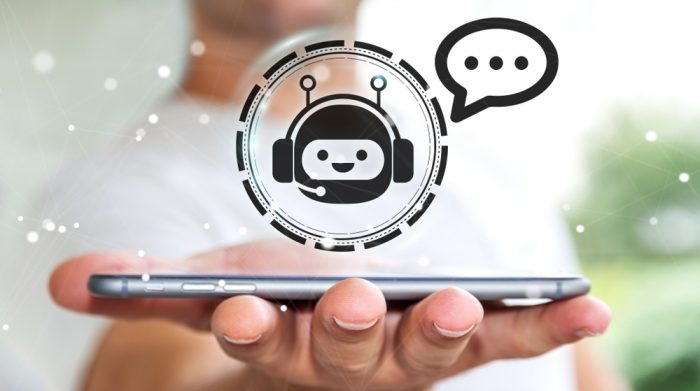

### 1\. **Contexto**

Os chatbots têm ganhado cada vez mais popularidade como uma forma eficiente de comunicação entre empresas e clientes. Esses assistentes virtuais são capazes de responder perguntas, fornecer informações e até mesmo realizar transações, tudo de forma automatizada e interativa.

No contexto de chatbots, a coleta e análise de dados desempenham um papel fundamental. A informação gerada a partir das interações dos usuários com o chatbot pode ser extremamente valiosa para a empresa. Esses dados, no entanto, podem ser divididos em duas categorias distintas: dados transacionais e dados analíticos:

* **Dados transacionais** referem-se a informações específicas de cada interação do usuário com o chatbot. Isso inclui mensagens enviadas, comandos executados e transações realizadas. Esses dados são cruciais para garantir que o chatbot funcione corretamente e forneça respostas precisas e relevantes aos usuários em tempo real.

* **Dados analíticos** são dados agregados e processados a partir das interações do usuário ao longo do tempo. Eles ajudam a compreender padrões de comportamento dos usuários, identificar tendências, realizar análises preditivas e extrair insights que podem direcionar decisões estratégicas da empresa.

O **objetivo do projeto** foi implementar uma pipeline completa e eficiente de dados utilizando a AWS, em um chatbot do Telegram, possibilitando a captura, armazenamento e processamento dos dados enviados pelos usuários. Com a infraestrutura montada, os dados foram preparados para análises posteriores, permitindo a extração de informações úteis e insights relevantes para a tomada de decisões.


## 2\. **Arquiterura**

A arquitetura proposta é composta por duas partes:
* **Transacional**: no Telegram, onde os dados são produzidos;
* **Analítica:** realizada na plataforma Amazon Web Services (AWS) onde ocorrerá todo o processamento, manipulação, armazenamento e análise dos dados.

A imagem abaixo demonstra todo o fluxo do pipeline de dados:

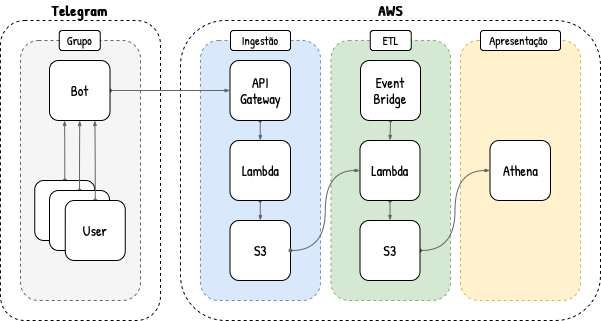

## **2.1 Sistema Transacional**

O Telegram representa a fonte de dados transacionais. Mensagens enviadas por usuários em um grupo são capturadas por um bot e redirecionadas via webhook do backend do aplicativo para um endpoint (endereço web que aceita requisições HTTP) exposto pelo AWS API Gateway. As mensagens trafegam no corpo ou payload da requisição.

No Telegram cria-se um bot para através de sua API TOKEN, acessar as mensagens enviadas no grupo do qual o bot faz parte.

Então teremos as seguintes etapas:

1. Criar um bot através do botfather



> Pesquisar por botfather e nele digitar /newbotloco


> O nome de usuário do bot (precisa terminar com sufixo _bot)


> Ative o bot abrindo o chat com o bot e clicando em start



2. Criar um grupo e adicionar o bot



> Clicar no símbolo lápis na parte inferior da tela para criar o grupo

> Ir no bot e adicioná-lo ao grupo


3. Tornar o bot administrador do grupo.

4. Desabilitar a opção de adicionar o bot a novos grupos.

> No BotFather < My Bots < Bot settings < Allow Groups

5. Enviar mensagens no grupo para capturá-las

6. Ir ao botfather, acessar o bot e pegar sua API Token

Através do Python e de um notebook:

* Criaremos uma variável Token com o valor da API TOKEN;

* Depois vamos inserir a variável Token na base_url

* Retornaremos as informações sobre o bot (apenas para verificação)

* E por fim retornaremos as informações sobre as mensagens

Obs.: Precisaremos da base_url (que contém os dados da API Token) para retornar informações sobre o bot (método getMe), retornar as mensagens captadas pelo bot (método getUpdates) e redirecionar as mensagens captadas pelo bot (Webhook).

In [ ]:
from getpass import getpass

token = getpass()

A `url` base é comum a todos os métodos da API.

In [ ]:
import json

import requests

base_url = f'https://api.telegram.org/bot{token}'

- **getMe**

O método `getMe` retorna informações sobre o *bot*.

In [ ]:
response = requests.get(url=f'{base_url}/getMe')
print(f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

 - **getUpdates**

O método `getMe` retorna as mensagens captadas pelo *bot*.

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

A tabela abaixo descreve os dados

| chave | tipo valor | opcional | descrição |
| -- | -- | -- | -- |
| updated_id | int | não | id da mensagem enviada ao **bot** |
| message_id | int | não | id da mensagem enviada ao grupo |
| from_id | int | sim | id do usuário que enviou a mensagem |
| from_is_bot | bool | sim | se o usuário que enviou a mensagem é um **bot** |
| from_first_name | str | sim | primeiro nome do usário que enviou a mensagem |
| chat_id | int | não | id do *chat* em que a mensagem foi enviada |
| chat_type | str | não | tipo do *chat*: private, group, supergroup ou channel |
| date | int | não | data de envio da mensagem no formato unix |
| text | str | sim | texto da mensagem |

**Importante:** Na informação das mensagens, temos o id do chat. É com ele que iremos configurar nossa função Lambda.

## **2.2 Sistema Analítico**

A etapa analítica do projeto consiste na:

1.  Ingestão;

2. ETL (extract, transform, load);

3. Apresentação dos dados.

Essa etapa foi realizada no Amazon Web Services (AWS) através dos serviços *API Gateway, Lambda, S3, EventBridge* e *Athena*.

## **2.2.1 AWS | Ingestão**

A etapa de ingestão é responsável por inserir os dados transacionais no ambiente analítico. Como o Telegram retem as mensagens por apenas 24 horas, a ingestão via streaming é a mais indicada para este projeto

Uma requisição HTTP com o conteúdo da mensagem em seu payload é recebia pelo AWS API Gateway que, por sua vez, as redireciona para o AWS Lambda, servindo assim como seu gatilho. Já o AWS Lambda recebe o payload da requisição em seu parâmetro event, salva o conteúdo em um arquivo no formato JSON (original, mesmo que o payload) e o armazena no AWS S3.

As mensagens capturadas pelo bot podem ser acessadas via API. A única requisição necessária é o token fornecido pelo botFather na criação do bot.

Para desenvolver o ambiente de ingestão foram seguidas as seguintes etapas:

* Criar um bucket no AWS S3;

* Criar uma função no AWS Lambda;

* Criar uma API web no AWS API Gateway;

* Configurar o webhook da API de bots do Telegram.





 * **AWS S3**

 O AWS S3 armazenará as mensagens captadas pelo bot do Telegram em um bucket que seguindo o padrão de data lake (repositório com grande volume dados), onde a organização dos dados armazenados é dada de acordo com os níveis de processamento, o bucket terá o sufixo -raw em seu nome pelo fato de os dados estarem em seu formato original: JSON

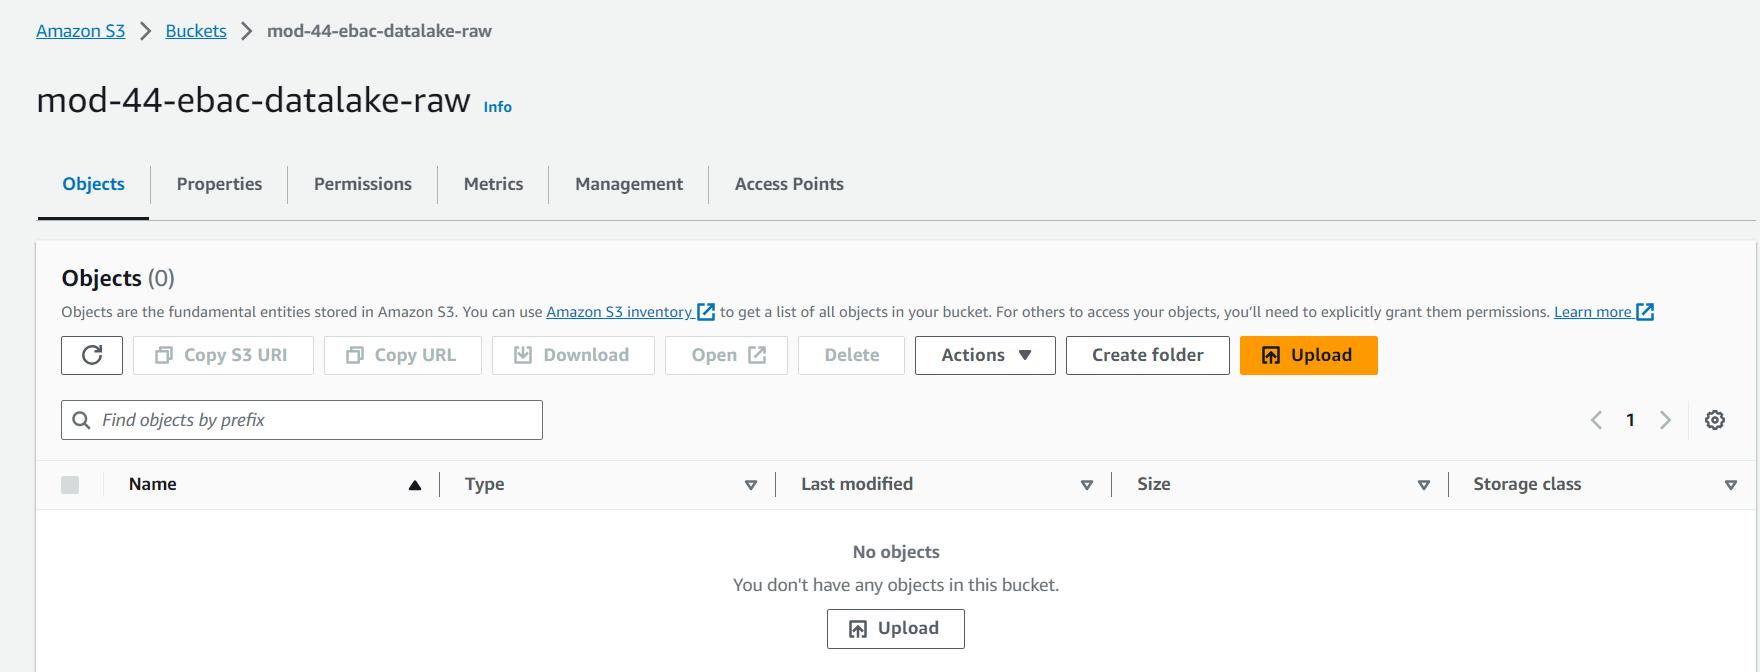

* **AWS Lambda:**

No AWS Lambda escreveremos uma função que receberá as mensagens do Telegram via AWS API Gateway através do parametro event, verificará se a mensagem veio do grupo correto, se sim a escreverá no bucket do AWS S3 em seu formato original JSON e retornará uma mensagem de sucesso.

Para que a função funcione corretamente, foram configuradas as variáveis de ambiente e  adicionadas as permissões de interação com `AWS S3` no `AWS IAM`.

* Variável de ambiente

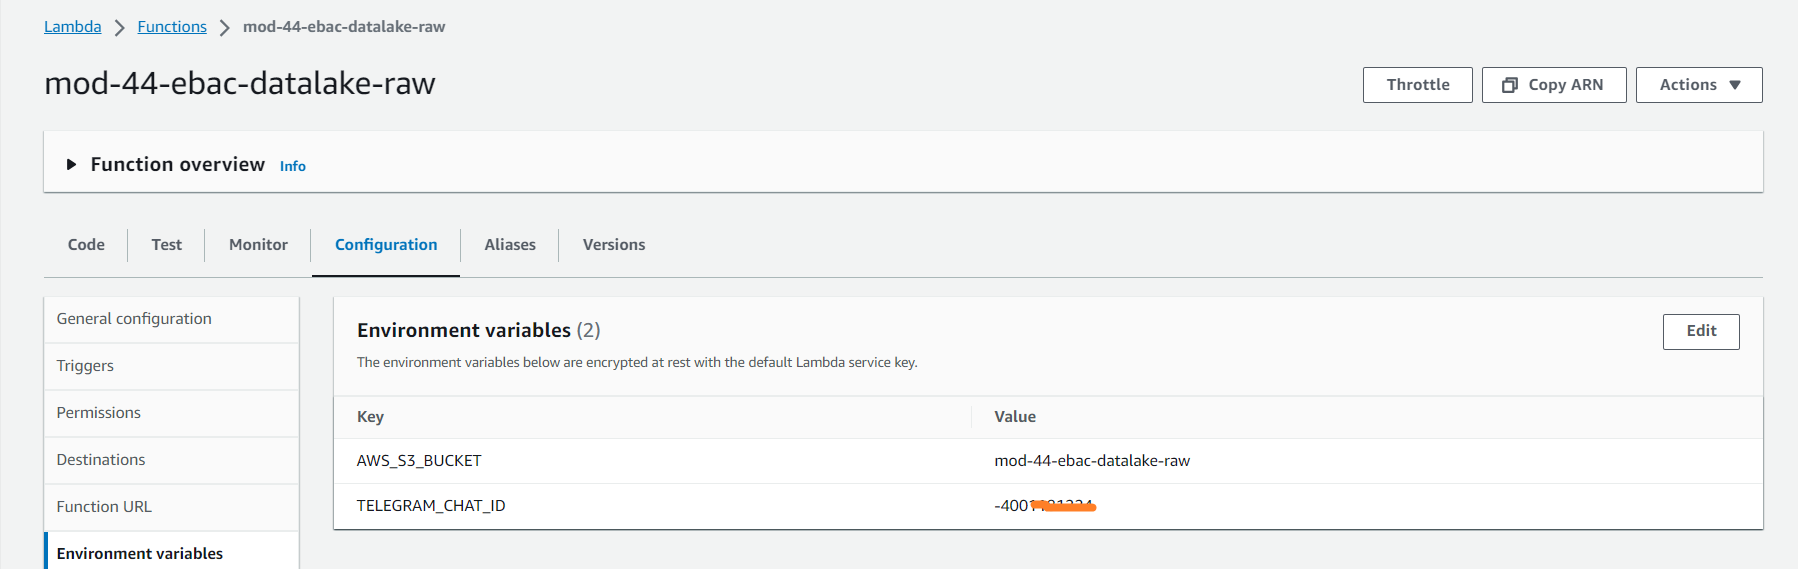

* Permissões

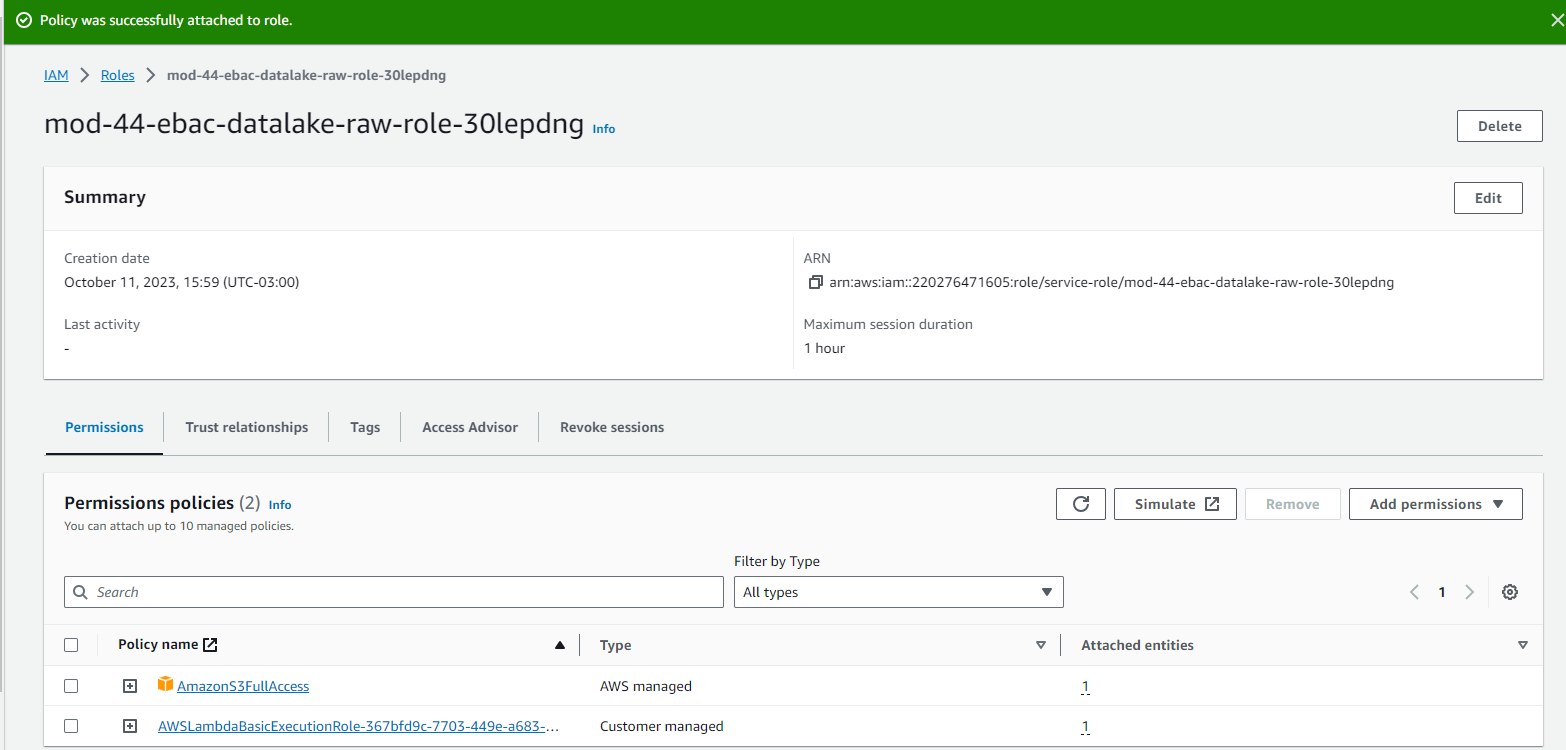

* Função no AWS Lambda



```python
# código da função

import os
import json
import logging
from datetime import datetime, timezone, timedelta

import boto3

def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    #message = event
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")
```





* Testando a função

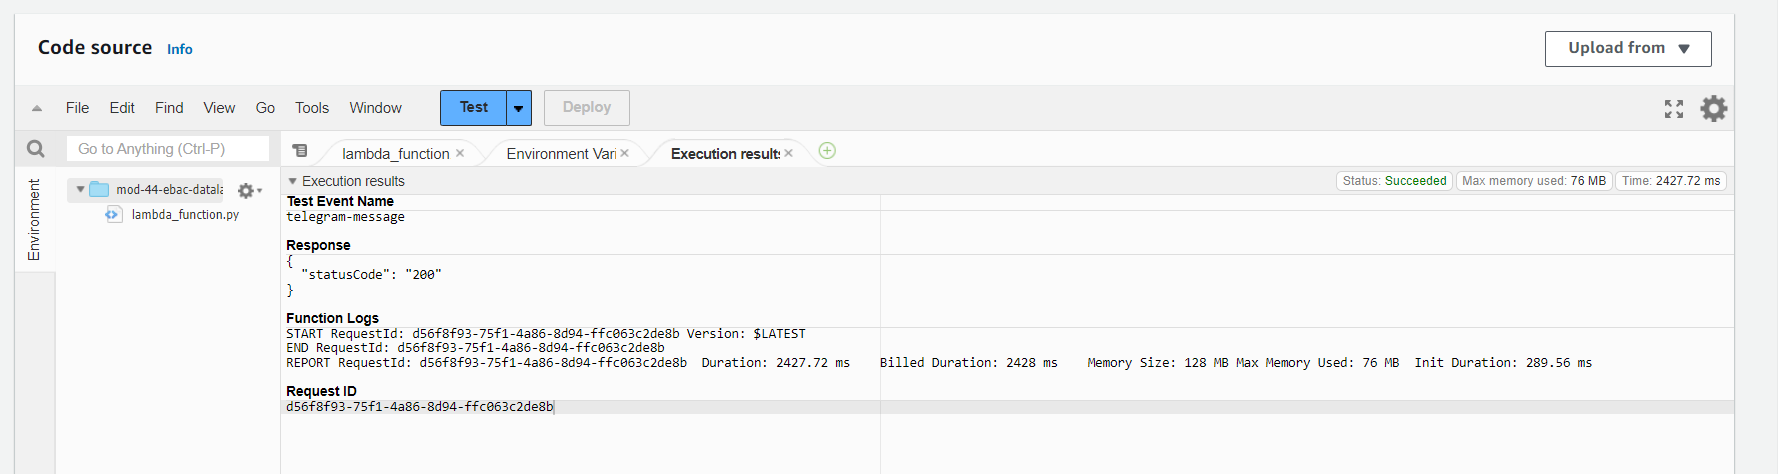

* objeto carregado no S3

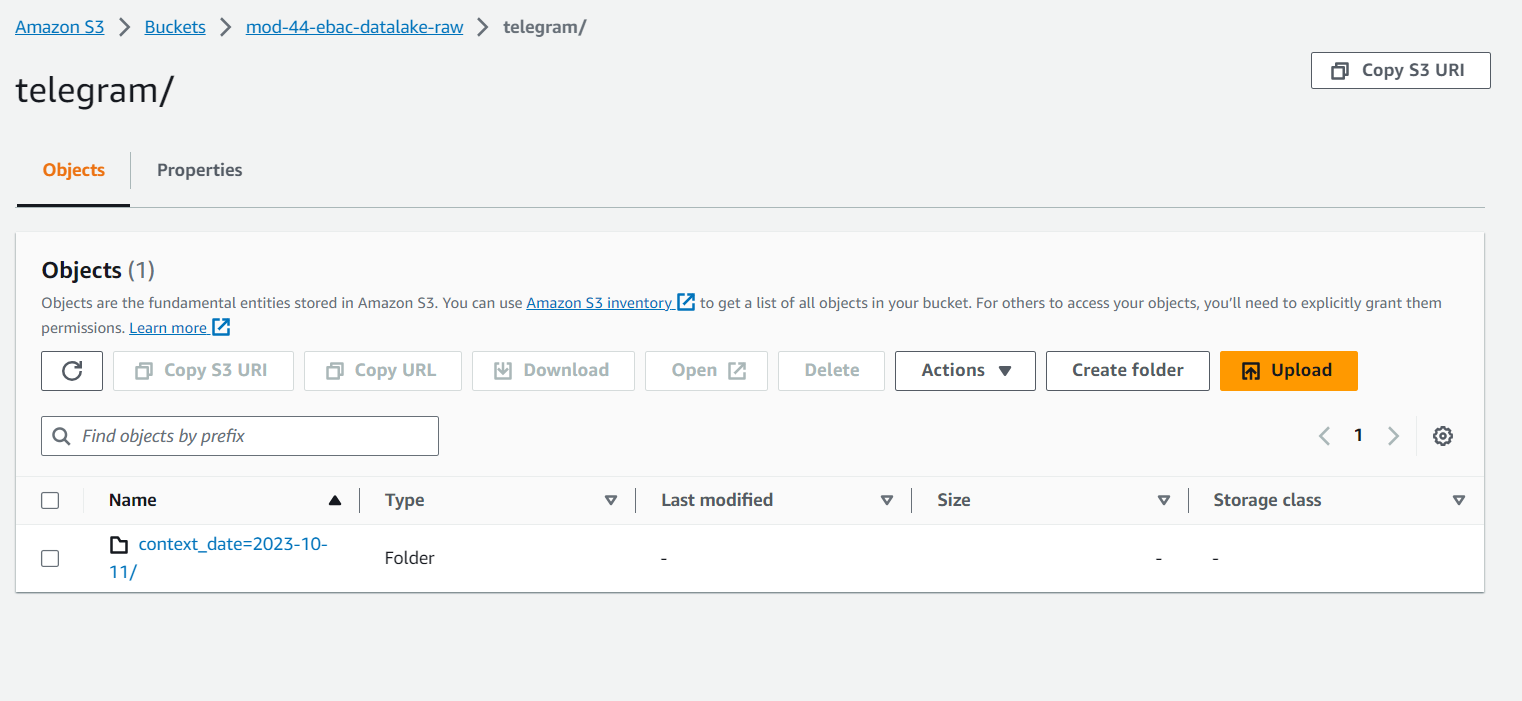

* **AWS API Gateway:**

 O AWS API Gateway receberá as mensagens do Telegram enviadas via webhook e iniciará uma função AWS Lambda, passando o conteúdo da mensagem no seu parâmetro event. Para isso criaremos uma API para configurá-la como gatilho da função do AWS Lambda e obter o seu endereço web.

Para testar a integração do AWS Lambda com a API, devemos fazer a implantação da API e obter seu endereço web. Com a url gerada, incluímos ela na variável **aws_api_gateway_url**.

In [ ]:
from getpass import getpass
aws_api_gateway_url = getpass()

O método **setWebhook** configura o redirecionamento das mensagens captadas pelo bot para o endereço web do parâmetro url, e o método **getWebhookInfo** retorna as informações sobre o webhook configurado.

Vamos configurar o *webhook* para redirecionar as mensagens para a `url` do `AWS API Gateway`.

 - **setWebhook**

In [ ]:
base_url = f'https://api.telegram.org/bot{token}'

In [ ]:
import requests
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

 - **getWebhookInfo**

In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

## **2.2.2 AWS | ETL**




A etapa de extração, transformação e carregamento (traduzido do inglês extract, transform, load) é uma camada abrangente, e seus processos podem variar dependendo da empresa, volumes e tipos de dados.

Em geral, o dado extraído pode passar por processos recorrentes de transformação (data wrangling), limpeza e agrupamento, e é persistido usando técnicas de particionamento, estando assim pronto para ser utilizado por profissinais da área de dados.

Na camada de ETL, as mensagens cruas de um único dia (D-1) armazenadas no bucket S3 serão manipuladas através de uma função do AWS Lambda, e compactadas em um arquivo orientado a coluna, passando também por alguns processos de data wrangling e enriquecimento.

Por fim, esses novos arquivos serão armazenados em um novo bucket, para posterior utilização na camada de apresentação.

Os passos seguidos nessa etapa foram os seguintes:

- Criação de um bucket no AWS S3;
- Criação de uma função no AWS Lambda;
- Configuração de um scheduler no AWS Event Bridge.

Foi criado o bucket "mod-44-ebac-datalake-enriched" para receber o arquivo processado no formato Apache Parquet:

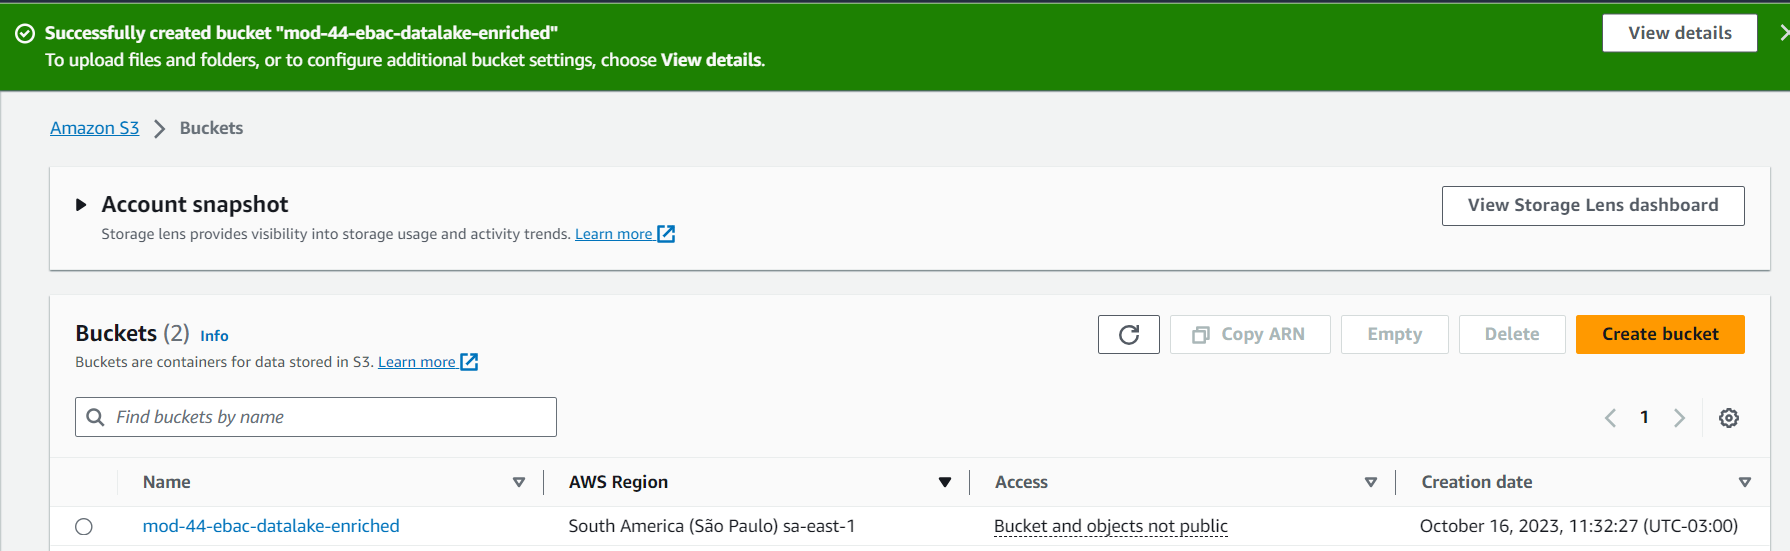

* Função no AWS Lambda



```python
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None
          
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False
      
      
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data
```



- Função Lambda Criada com suas respectivas variáveis de ambiente, permissões, recursos e camadas

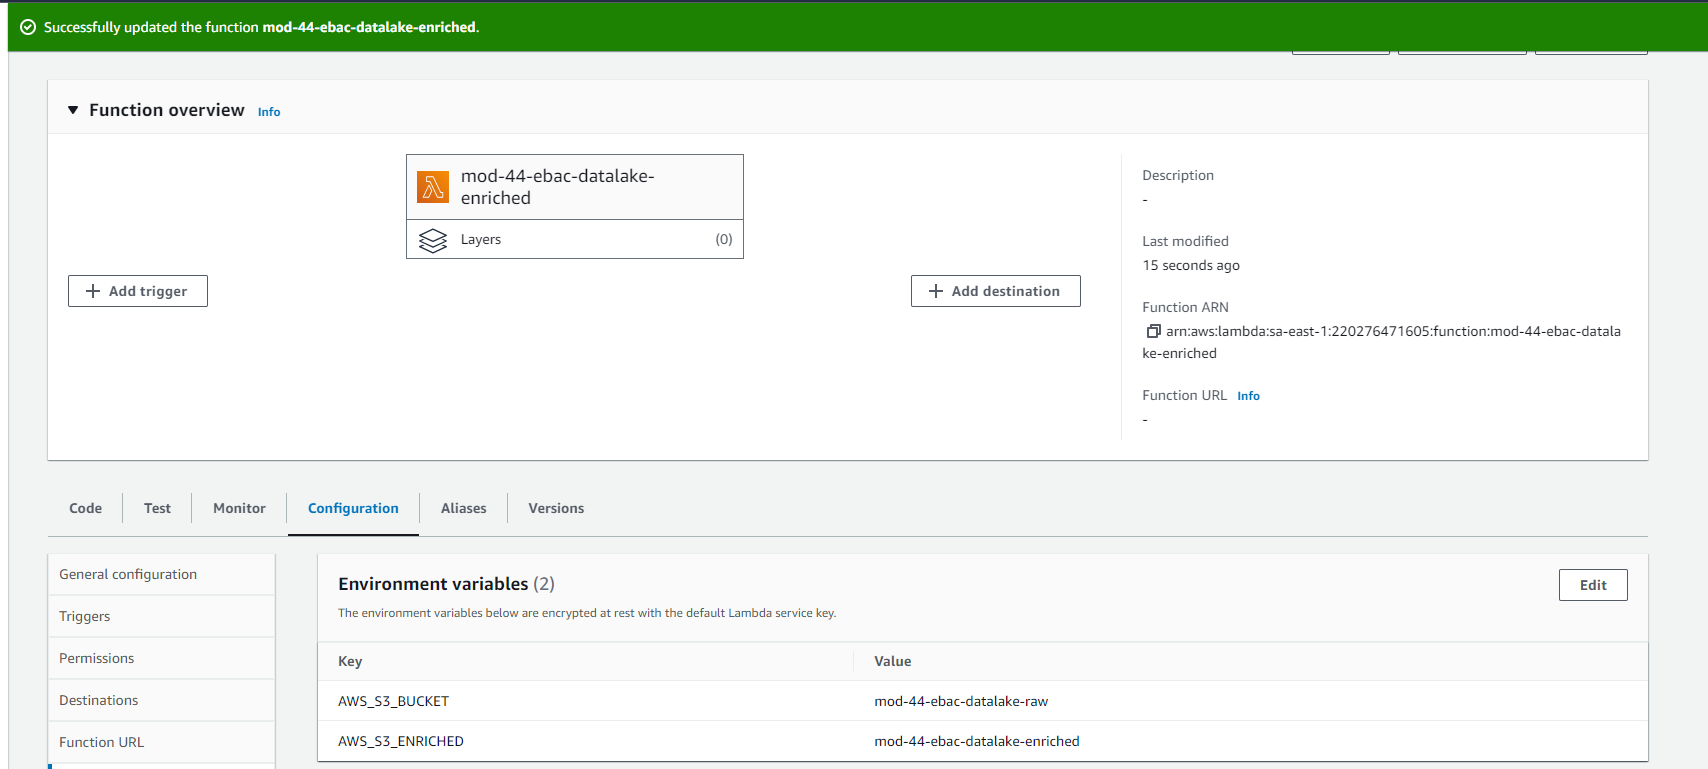

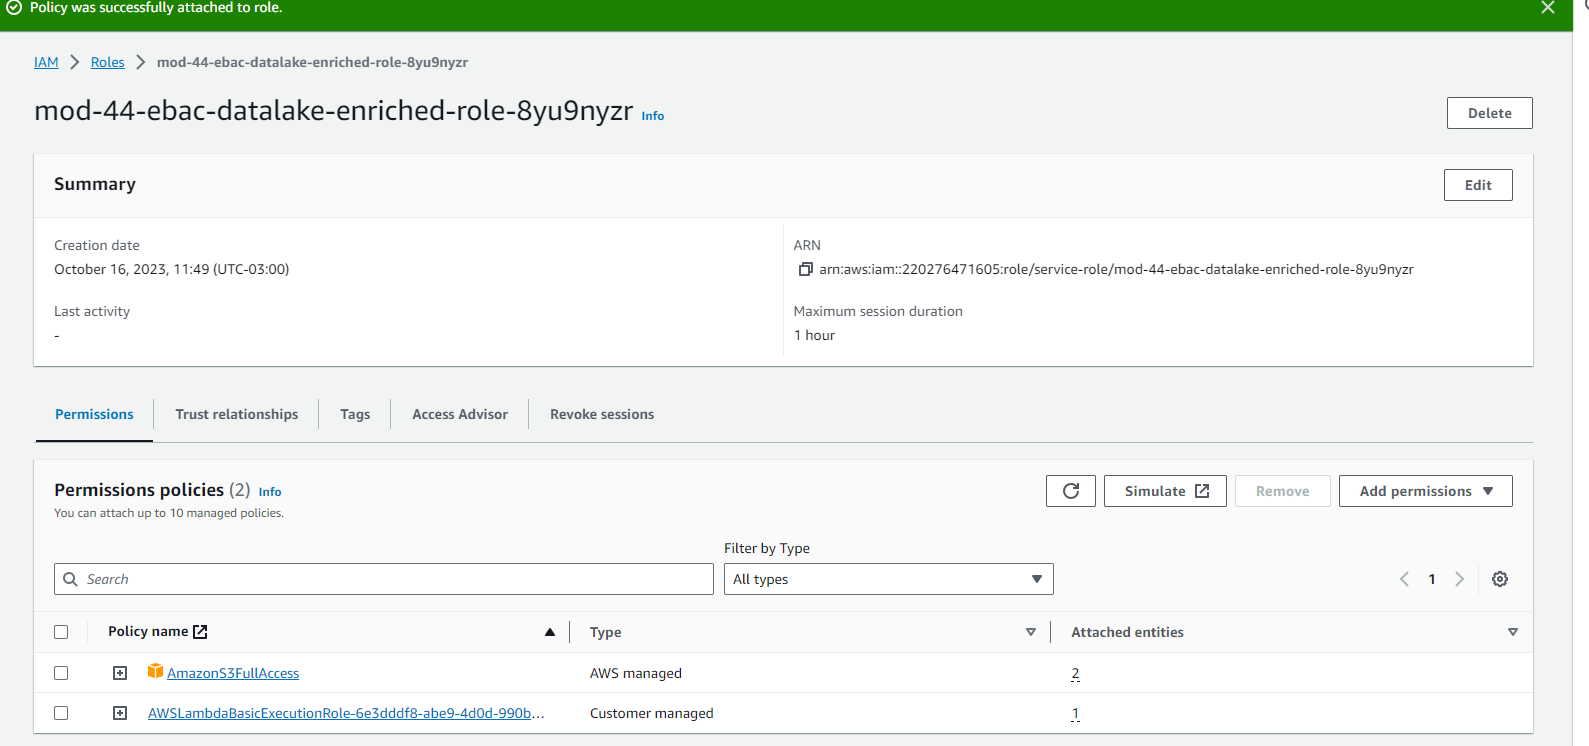

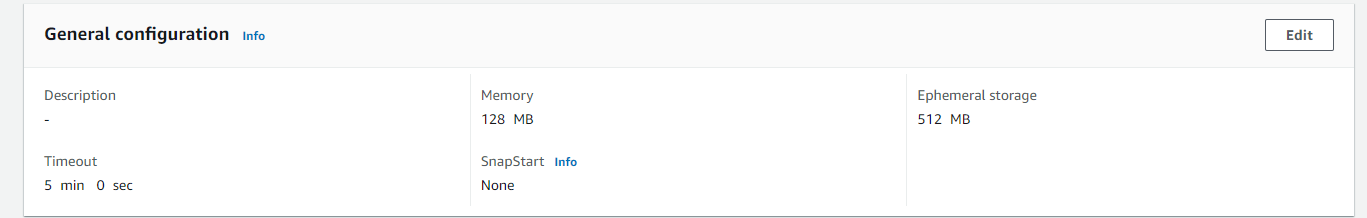

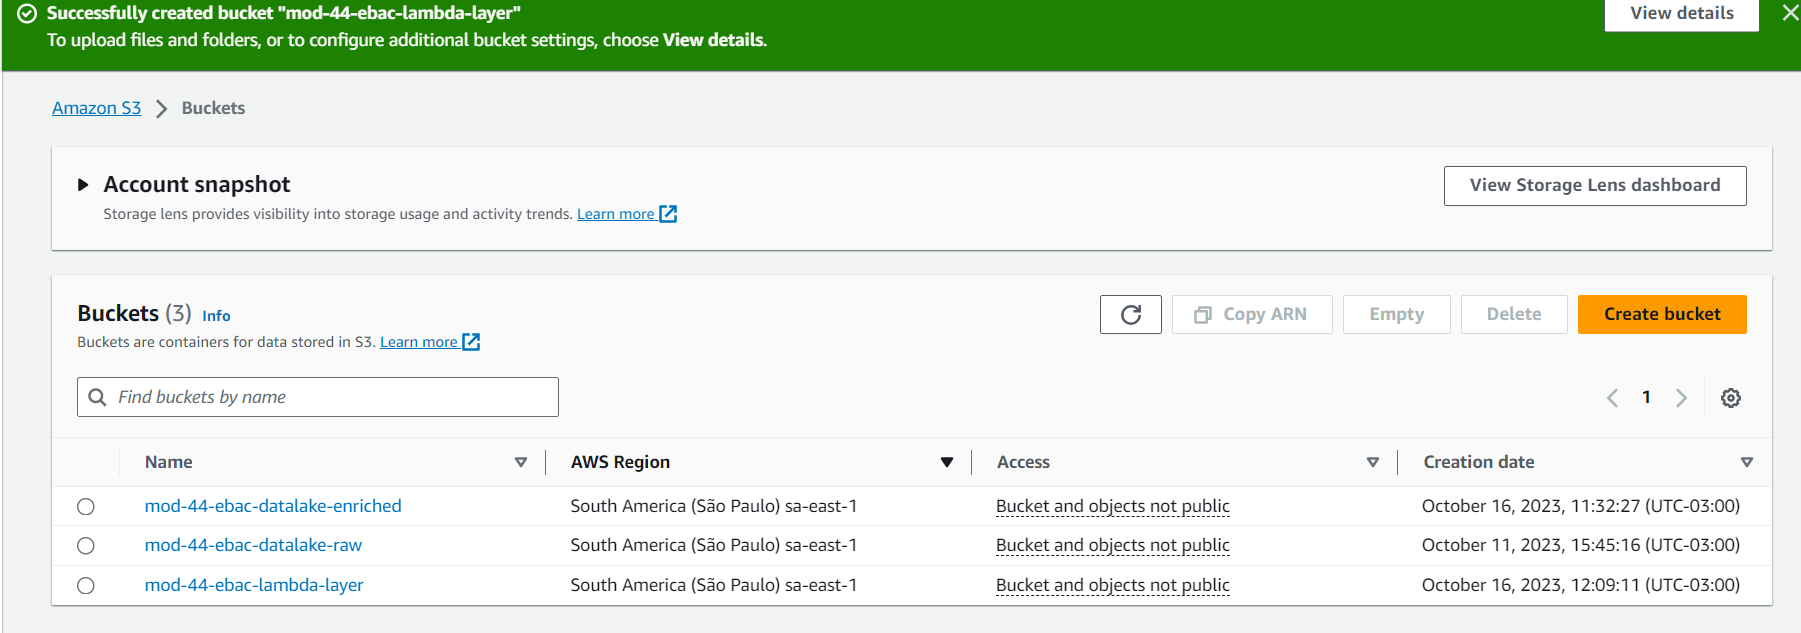

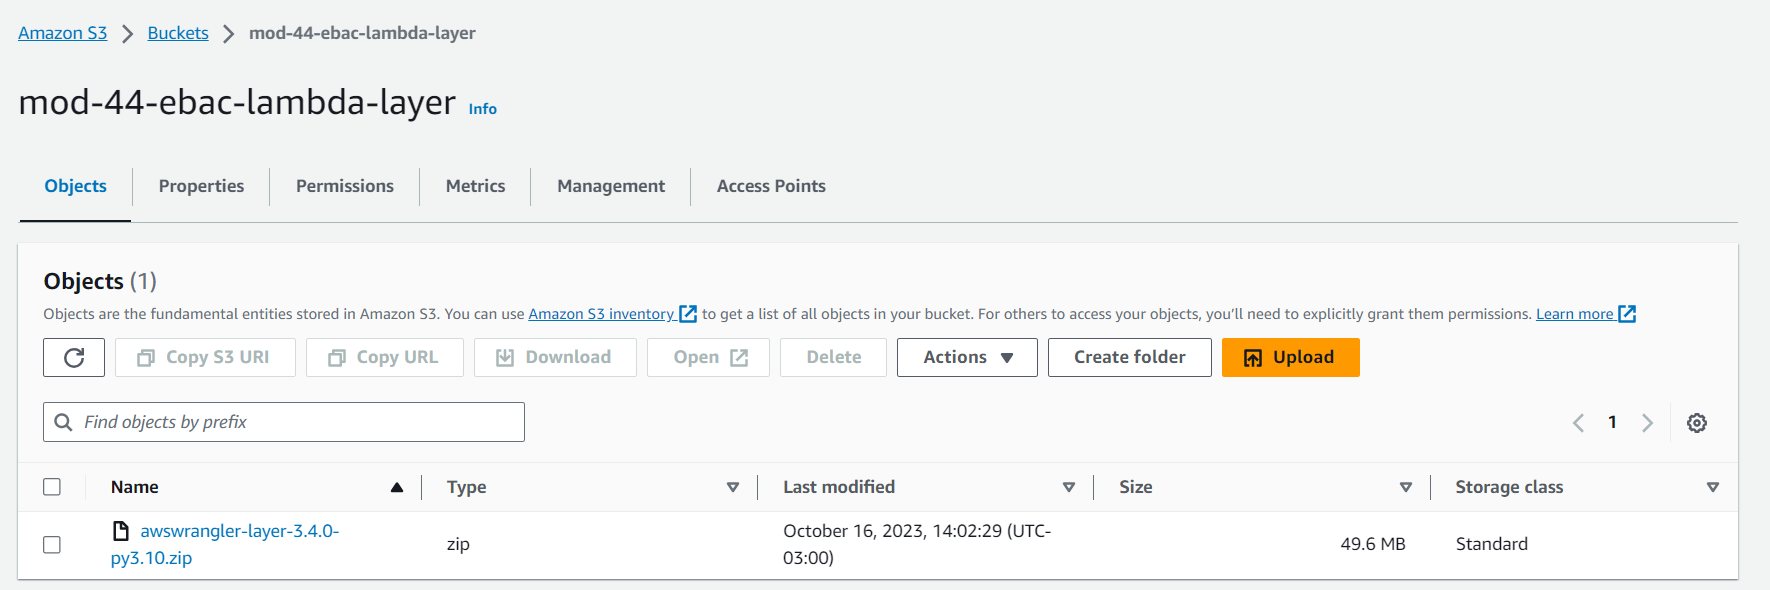

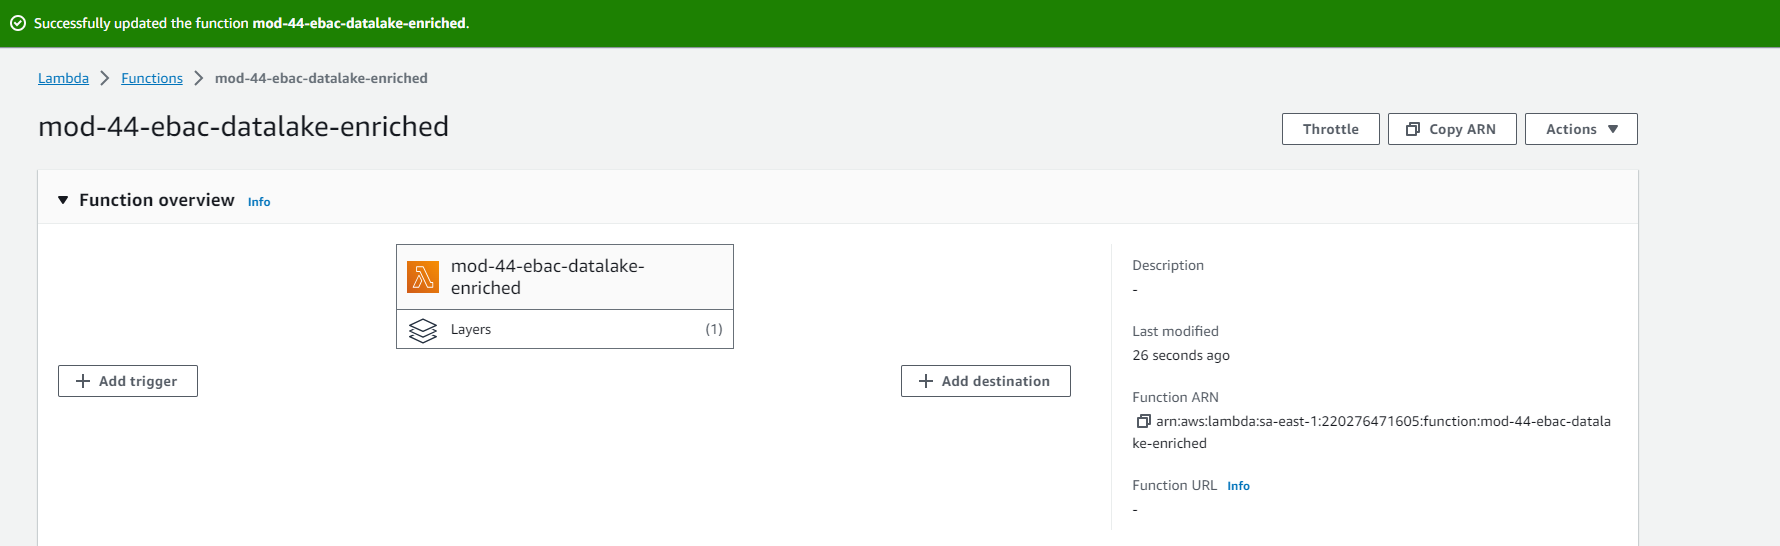

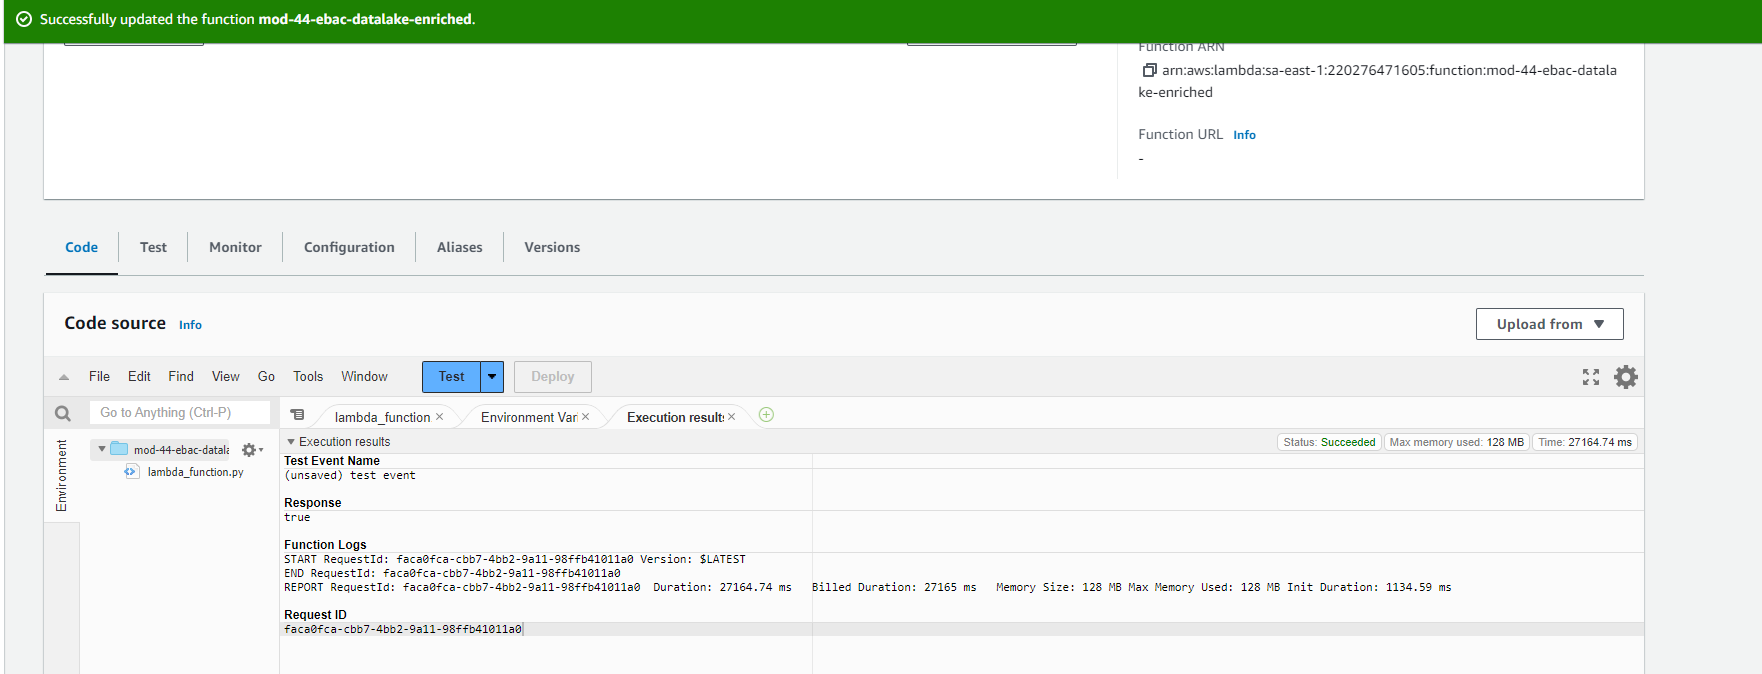

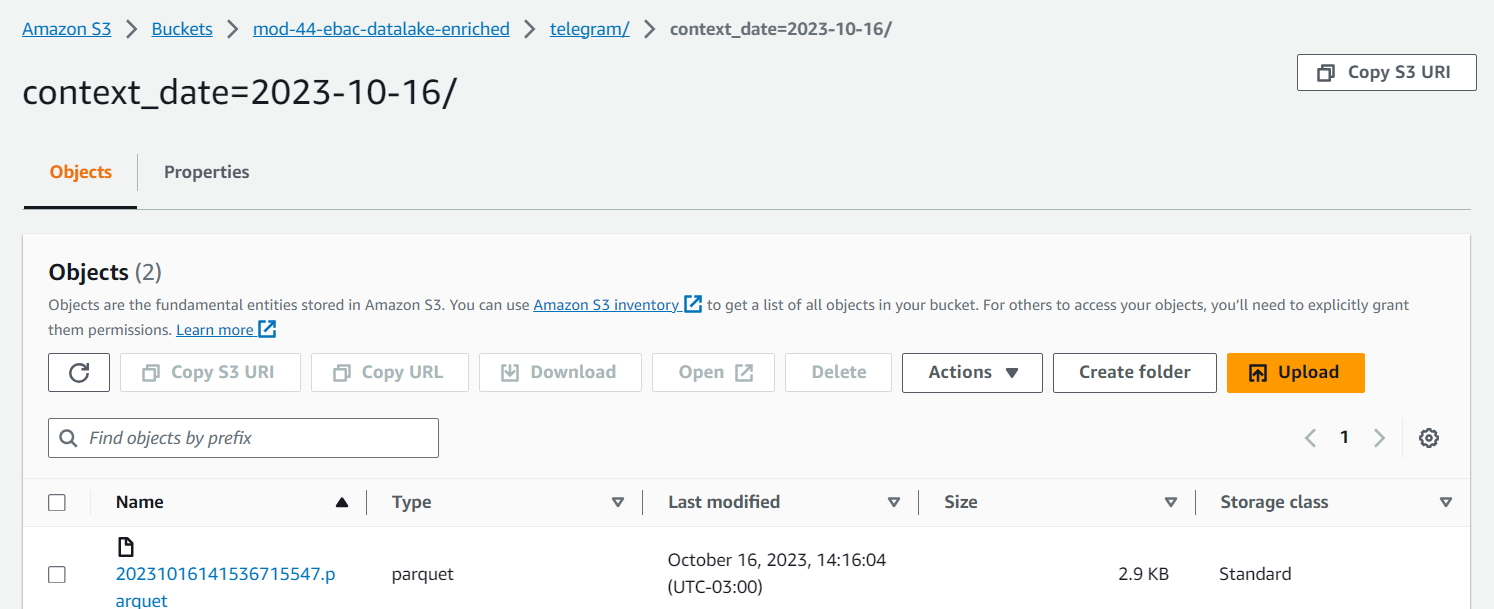

Foi criada uma regra no `AWS Event Bridge` para executar a função do `AWS Lambda` todo dia a meia noite no horário de Brasília (GMT-3).

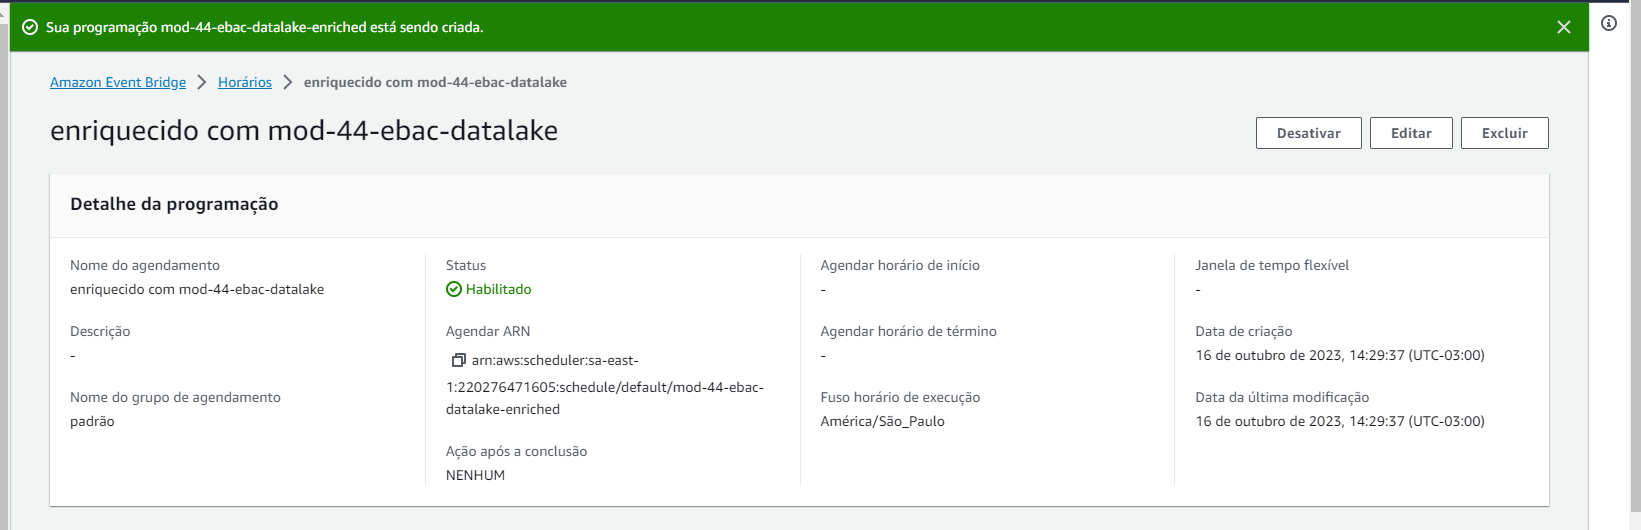


## **2.2.3 AWS | Apresentação**

Por fim, uma tabela do AWS Athena é apontada para o bucket do AWS S3 que armazena o dado processado: denormalizado, particionado e orientado a coluna. Profissionais de dados podem então executar consultas analíticas (agregações, ordenações, etc.) na tabela utilizando o SQL para a extração de insights.

- Criando a tabela "telegram" no AWS Athena

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'
```

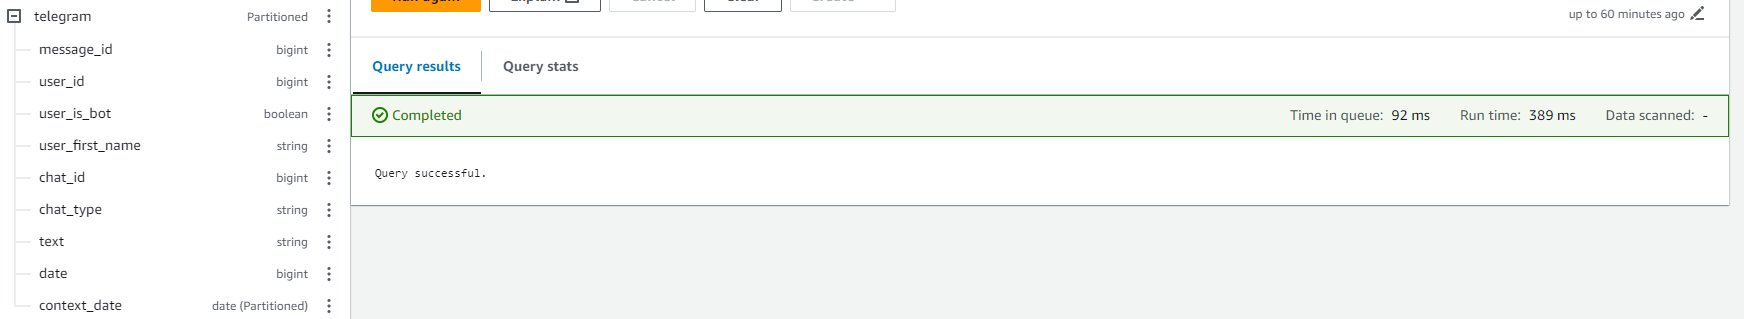

- Carregando partições na tabela "telegram".

```sql
MSCK REPAIR TABLE `telegram`;
```

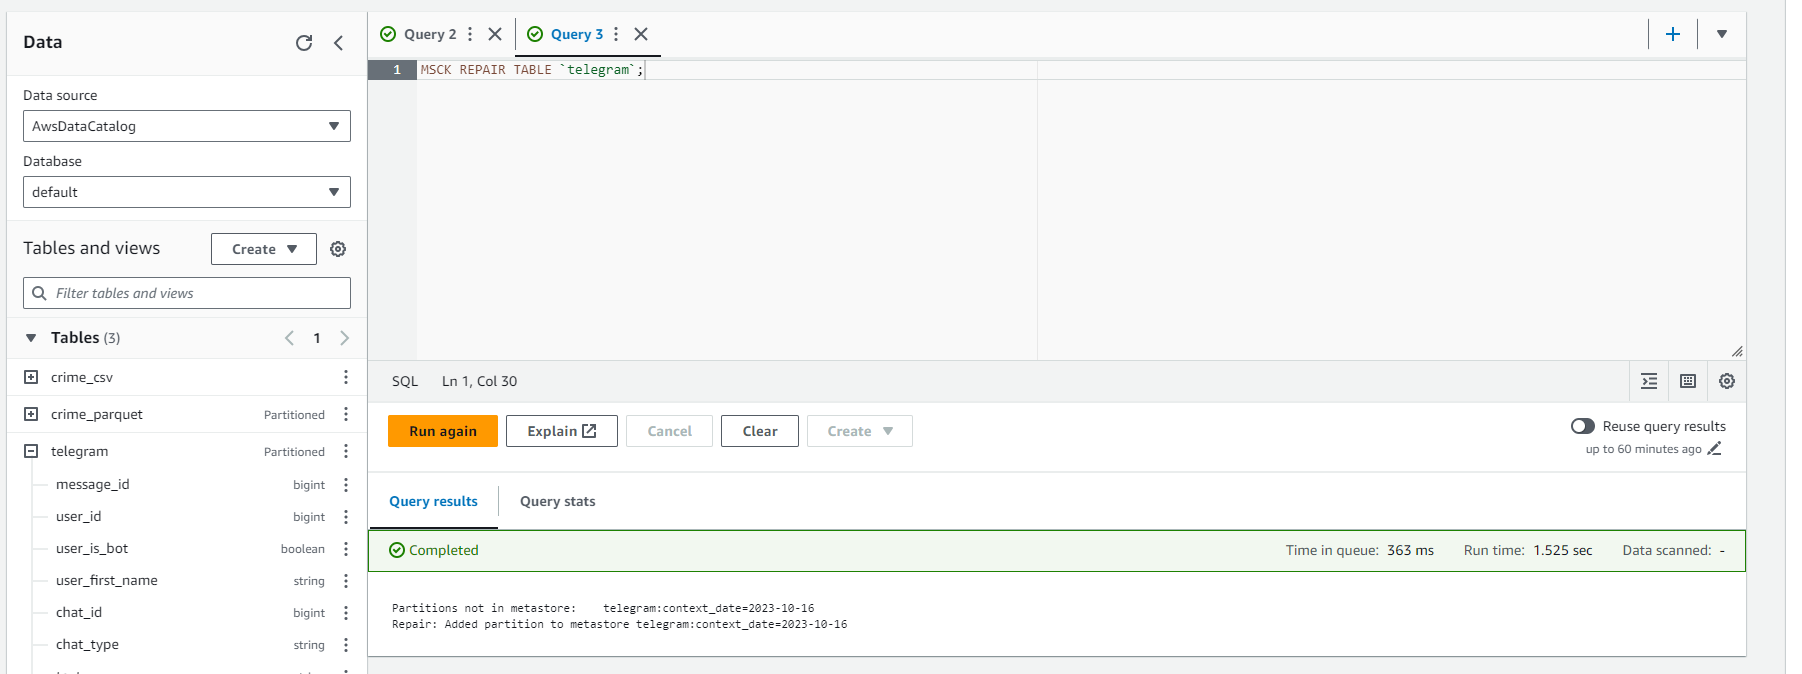

## 3\. **Analytics**

Com os dados disponíveis, os usuários podem executar as mais variadas consultas analíticas e extrais insights.

Seguem alguns exemplos didáticos, pois nesse caso os conteúdos das mensagens não serão analisados a fundo:

- Visualizando as 10 primeiras linhas da tabela:

```sql
SELECT * FROM `telegram` LIMIT 10;
```

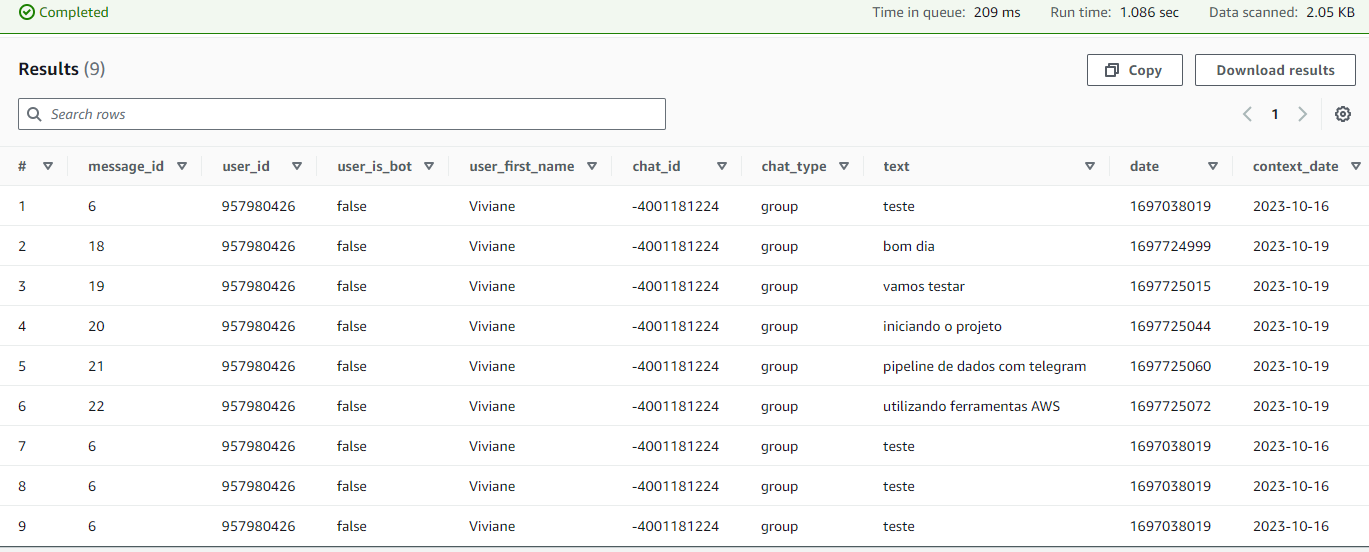

- Quantidade de mensagens por dia

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

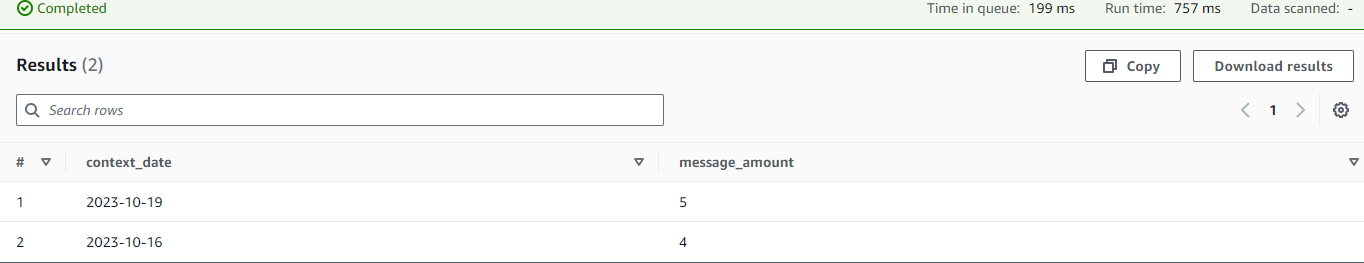

- Quantidade de mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

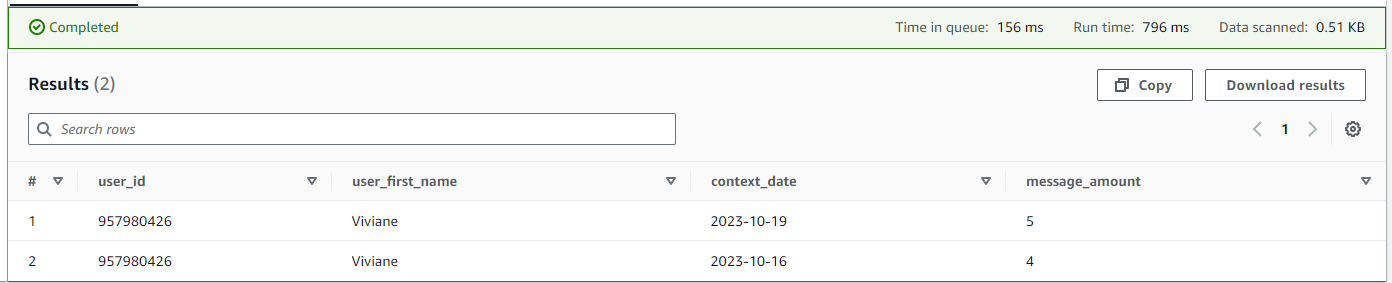